In [17]:
import sys
sys.path.insert(1, '../src')

import numpy as np
import matplotlib.pyplot as plt 
import torch
import gzip
import pickle
import h5py

from TMCRBM import TMCRBM

device = torch.device("cuda")
dtype = torch.float

In [18]:
f = gzip.open('../dataset/mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, _, _ = p

data = torch.as_tensor(train_set[0][:10000,:].T, device = device, dtype = dtype)

# TRAINING

In [3]:
Nv = data.shape[0]
Nh = 100

lr = 0.01
NGibbs = 50
mb_s = 200
num_pcd = 200
ep_max = 1000

# steps used for the temporal mean
it_mean = 20
# constraint on the gaussian bath
N = 20000
# nb of chains for each constraint point
nb_chain = 15
# nb of constraint point
nb_point = 1000
# if True uses PCA for the projection else uses the SVD of the weight matrix
PCA = True
# index of the direction you want to put the constraints on (careful : first direction is 0, second is 1 etc...)
direction = 2
# the distance added to the extremas of the data projection for the discretization
border_length = 0.2
# if you want to save the plot of the data projection + potential during the learning
save_fig = False


In [4]:
stamp = 'TMCRBM_MNIST_NGibbs_'+str(NGibbs)+'_Nh'+str(Nh)+'_Nv' + str(Nv)+'_Nmb'+str(mb_s)+'_Nepoch'+str(ep_max)+'_lr_'+str(lr) + '_N' + str(N) + '_Npoint' + str(nb_point) + '_Nchain' + str(nb_chain)

In [5]:
myRBM = TMCRBM(num_visible=Nv,
               num_hidden=Nh,
               device=device,
               lr=lr,
               gibbs_steps=NGibbs,
               UpdCentered=True,
               mb_s=mb_s,
               num_pcd=num_pcd,
               N = N,
               nb_chain = nb_chain,
               nb_point=nb_point,
               direction=direction,
               PCA = PCA,
               border_length = border_length,
               save_fig = save_fig
              )

In [6]:
fq_msr_RBM = 10
myRBM.file_stamp = stamp
base = 1.7
v = np.array([0,1],dtype=int)
allm = np.append(np.array(0),base**np.array(list(range(30))))
for k in range(30):
    for m in allm:
        v = np.append(v,int(base**k)+int(m)) 
v = np.array(list(set(v)))
v = np.sort(v)
myRBM.list_save_time = v
myRBM.list_save_rbm = np.arange(1, ep_max, fq_msr_RBM)



In [ ]:
myRBM.SetVisBias(data)
myRBM.fit(data, ep_max)

# SAMPLING

In [19]:
f_name_tmc = "../model/TMC1D/MNIST/AllParametersTMCRBM_MNIST2_NGibbs_50_Nh100_Nv784_Nmb200_Nepoch1000_lr_0.01_N20000_Npoint1000_Nchain15.h5"
f_tmc = h5py.File(f_name_tmc, "r")
alltimes = []
for t in f_tmc['alltime'][:]:
    if 'W'+str(t) in f_tmc:
        alltimes.append(t)
alltimes = np.array(alltimes)

In [20]:
lr = 0.01
NGibbs = 50
mb_s = 200
num_pcd = 200
Nh = torch.tensor(f_tmc['W0']).shape[0]
Nv = data.shape[0]
# steps used for the temporal mean
it_mean = 20
# constraint on the gaussian bath
N = 20000
# nb of chains for each constraint point
nb_chain = 15
# nb of constraint point
nb_point = 1000
# if True uses PCA for the projection else uses the SVD of the weight matrix
PCA = True
# index of the direction you want to put the constraints on (careful : first direction is 0, second is 1 etc...)
direction = 2
# the distance added to the extremas of the data projection for the discretization
border_length = 0.2

RBM_TMC = TMCRBM(num_visible=Nv,
                num_hidden=Nh,
                device=device,
                lr=lr,
                gibbs_steps=NGibbs,
                UpdCentered=True,
                mb_s=mb_s,
                direction=direction,
                PCA = PCA,
                num_pcd=num_pcd)
_, _, V = torch.svd(RBM_TMC.W)

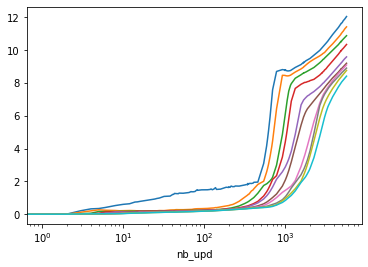

In [21]:
nvalsing = 10
S = torch.zeros(nvalsing, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f_tmc['W'+str(t)], device = device))
    if torch.mean(tmpV[:,0])<0:
        tmpV = -tmpV
    S[:,i] = tmpS[:nvalsing]
plt.plot(alltimes,S.T.cpu())
plt.semilogx()
plt.xlabel("nb_upd");

In [22]:
t = alltimes[-1]

RBM_TMC.W = torch.tensor(f_tmc['W'+str(t)], device = RBM_TMC.device)
RBM_TMC.hbias = torch.tensor(f_tmc['hbias'+str(t)], device = RBM_TMC.device)
RBM_TMC.vbias = torch.tensor(f_tmc['vbias'+str(t)], device = RBM_TMC.device)
_, S_tmc, V_tmc = torch.svd(RBM_TMC.W)

In [23]:
RBM_TMC.computeProbabilityAnalysis(data)

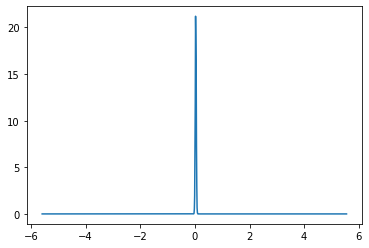

In [14]:
plt.plot(RBM_TMC.w_hat_b.cpu()[1:], RBM_TMC.p_m.cpu())

array([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,   12,
         14,   15,   16,   18,   22,   24,   25,   26,   28,   32,   38,
         41,   42,   43,   45,   48,   49,   55,   65,   69,   70,   71,
         73,   77,   82,   83,   93,  110,  118,  119,  120,  122,  126,
        132,  138,  142,  159,  187,  201,  202,  203,  205,  209,  215,
        225,  236,  242,  270,  319,  342,  343,  344,  346,  350,  356,
        366,  383,  402,  411,  460,  543,  582,  583,  584,  586,  590,
        596,  606,  623,  651,  684,  700,  783,  924,  990,  991,  992,
        994,  998, 1004, 1014, 1031, 1059, 1108, 1164, 1191, 1332, 1572,
       1683, 1684, 1685, 1687, 1691, 1697, 1707, 1724, 1752, 1801, 1884,
       1980, 2025, 2265, 2673, 2862, 2863, 2864, 2866, 2870, 2876, 2886,
       2903, 2931, 2980, 3063, 3204, 3366, 3444, 3852, 4545, 4866, 4867,
       4868, 4870, 4874, 4880, 4890, 4907, 4935, 4984, 5067, 5208, 5448,
       5724])